In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_monthly_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")
df.head()

Shape: (12984, 60)

Columnas (60):
   1. codigo_departamento
   2. area
   3. codigo_municipio
   4. Shape_Leng
   5. Shape_Area
   6. n_centros_poblados
   7. anio
   8. mes
   9. total_delitos
  10. ABIGEATO
  11. AMENAZAS
  12. DELITOS SEXUALES
  13. EXTORSION
  14. HOMICIDIOS
  15. HURTOS
  16. LESIONES
  17. VIOLENCIA INTRAFAMILIAR
  18. femenino_adolescentes
  19. femenino_adultos
  20. femenino_menores
  21. masculino_adolescentes
  22. masculino_adultos
  23. masculino_menores
  24. poblacion_total
  25. poblacion_menores
  26. poblacion_adultos
  27. poblacion_adolescentes
  28. area_km2
  29. densidad_poblacional
  30. centros_por_km2
  31. proporcion_menores
  32. proporcion_adultos
  33. proporcion_adolescentes
  34. fecha
  35. trimestre
  36. es_fin_ano
  37. n_dias_semana
  38. n_fines_de_semana
  39. n_festivos
  40. n_dias_laborales
  41. tasa_abigeato
  42. tasa_amenazas
  43. tasa_delitos sexuales
  44. tasa_extorsion
  45. tasa_homicidios
  46. tasa_hurtos
  47. tas

,codigo_departamento,area,codigo_municipio,Shape_Leng,Shape_Area,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,...,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,tasa_abigeato,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,mes_sin,mes_cos,lag_1,lag_3,lag_12,roll_mean_3,roll_mean_12,roll_std_3,roll_std_12,pct_change_1,pct_change_3,pct_change_12
0,68,152.915686,68001,0.693489,0.012514,1,2010,1,486,0,26,22,3,11,36,283,105,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,209,95,22,187,0.0,2.480774,2.099116,0.286243,1.049558,3.434918,27.002271,10.018510,0.5,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68,152.915686,68001,0.693489,0.012514,1,2010,2,353,0,11,24,2,14,21,245,36,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,166,70,0,166,0.0,1.049558,2.289945,0.190829,1.335801,2.003702,23.376524,3.434918,0.866025,0.5,486.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.273663,NaN,NaN
2,68,152.915686,68001,0.693489,0.012514,1,2010,3,438,0,21,30,2,13,17,301,54,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,201,72,6,195,0.0,2.003702,2.862432,0.190829,1.240387,1.622045,28.719730,5.152377,1.0,0.0,353.0,NaN,NaN,425.666667,NaN,67.352308,NaN,0.240793,NaN,NaN
3,68,152.915686,68001,0.693489,0.012514,1,2010,4,484,0,47,24,2,8,20,316,67,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,225,77,16,209,0.0,4.484476,2.289945,0.190829,0.763315,1.908288,30.150946,6.392764,0.866025,-0.5,438.0,486.0,NaN,425.000000,NaN,66.460515,NaN,0.105023,-0.004115,NaN
4,68,152.915686,68001,0.693489,0.012514,1,2010,5,505,0,35,35,2,17,30,299,87,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,220,95,19,212,0.0,3.339503,3.339503,0.190829,1.622045,2.862432,28.528901,8.301051,0.5,-0.866025,484.0,353.0,NaN,475.666667,NaN,34.268547,NaN,0.043388,0.430595,NaN


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal registros: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"Meses cubiertos: {df.groupby(['anio', 'mes']).ngroups}")

# Valores nulos
print(f"\nValores nulos (top 10):")
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls[nulls > 0].head(10) if any(nulls > 0) else "Ninguno")

INFO GENERAL

Total registros: 12,984
Período: 2010 - 2025
Municipios: 87
Meses cubiertos: 190

Valores nulos (top 10):
pct_change_12    1044
lag_12           1044
roll_mean_12      957
roll_std_12       957
lag_3             261
pct_change_3      261
roll_mean_3       174
roll_std_3        174
lag_1              87
pct_change_1       87
dtype: int64


## 1. Distribución de total_delitos

In [4]:
# Estadísticas del target principal
print("=" * 60)
print("ESTADÍSTICAS: total_delitos")
print("=" * 60)
print(df['total_delitos'].describe())

# Percentiles adicionales
print(f"\nPercentiles adicionales:")
for p in [1, 5, 95, 99]:
    print(f"  P{p}: {df['total_delitos'].quantile(p/100):.0f}")

ESTADÍSTICAS: total_delitos
count    12984.000000
mean        37.138016
std        135.662311
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max       1769.000000
Name: total_delitos, dtype: float64

Percentiles adicionales:
  P1: 1
  P5: 1
  P95: 203
  P99: 840


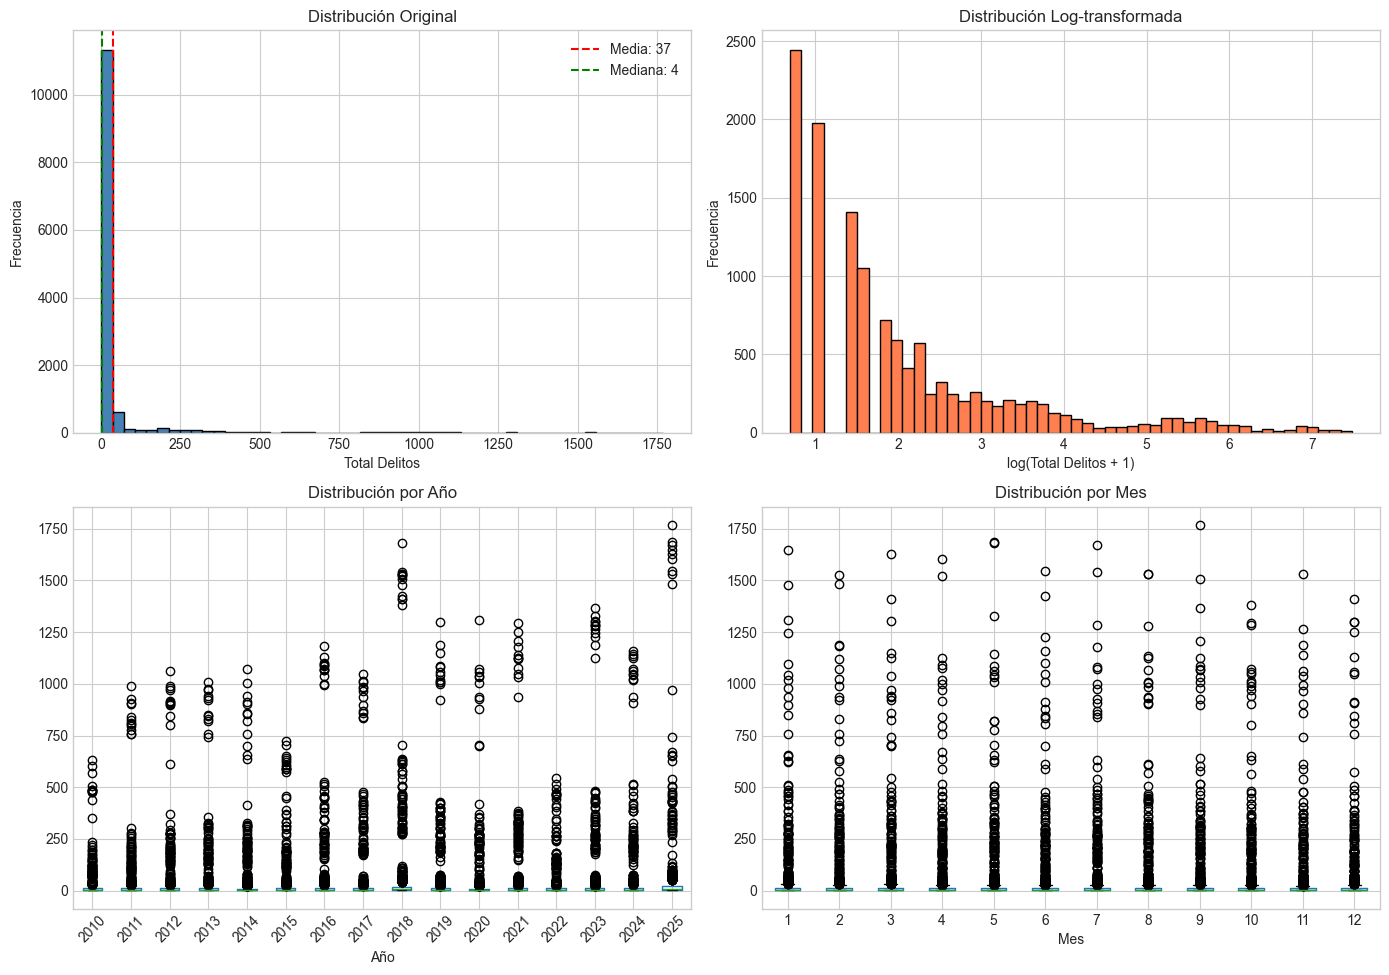

In [5]:
# Visualización de la distribución
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma original
axes[0, 0].hist(df['total_delitos'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Total Delitos')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución Original')
axes[0, 0].axvline(df['total_delitos'].mean(), color='red', linestyle='--', label=f'Media: {df["total_delitos"].mean():.0f}')
axes[0, 0].axvline(df['total_delitos'].median(), color='green', linestyle='--', label=f'Mediana: {df["total_delitos"].median():.0f}')
axes[0, 0].legend()

# Log-transform
df_log = np.log1p(df['total_delitos'])
axes[0, 1].hist(df_log, bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('log(Total Delitos + 1)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución Log-transformada')

# Boxplot por año
df.boxplot(column='total_delitos', by='anio', ax=axes[1, 0])
axes[1, 0].set_title('Distribución por Año')
axes[1, 0].set_xlabel('Año')
axes[1, 0].tick_params(axis='x', rotation=45)
plt.suptitle('')

# Boxplot por mes
df.boxplot(column='total_delitos', by='mes', ax=axes[1, 1])
axes[1, 1].set_title('Distribución por Mes')
axes[1, 1].set_xlabel('Mes')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 2. Análisis de Estacionalidad

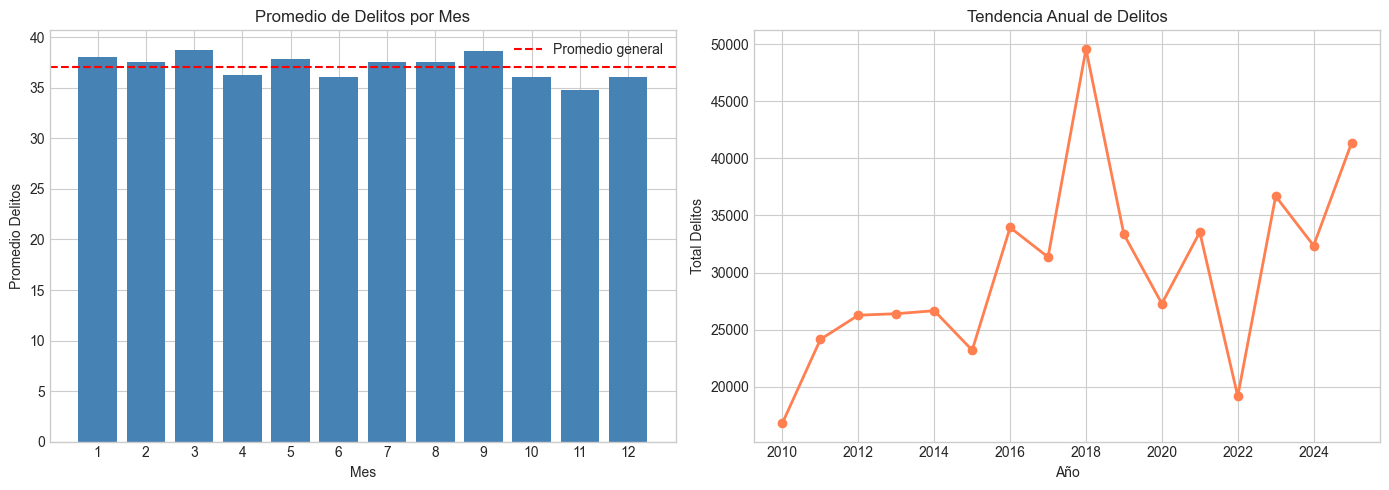


Coeficiente de Variación por Mes:
          mean         std     cv
mes                              
1    38.045740  136.653767  359.2
2    37.543336  136.238508  362.9
3    38.754113  138.075410  356.3
4    36.291080  132.691321  365.6
5    37.874549  139.623372  368.6
6    36.089401  131.323297  363.9
7    37.546263  137.195230  365.4
8    37.579606  137.792665  366.7
9    38.665150  144.228412  373.0
10   36.041404  131.226309  364.1
11   34.751731  128.845178  370.8
12   36.127421  132.902109  367.9


In [6]:
# Estacionalidad mensual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Promedio por mes (todos los años)
monthly_avg = df.groupby('mes')['total_delitos'].mean()
axes[0].bar(monthly_avg.index, monthly_avg.values, color='steelblue')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Promedio Delitos')
axes[0].set_title('Promedio de Delitos por Mes')
axes[0].set_xticks(range(1, 13))
axes[0].axhline(monthly_avg.mean(), color='red', linestyle='--', label='Promedio general')
axes[0].legend()

# Tendencia anual
yearly_total = df.groupby('anio')['total_delitos'].sum()
axes[1].plot(yearly_total.index, yearly_total.values, marker='o', linewidth=2, color='coral')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Total Delitos')
axes[1].set_title('Tendencia Anual de Delitos')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Coeficiente de variación por mes
print("\nCoeficiente de Variación por Mes:")
cv_by_month = df.groupby('mes')['total_delitos'].agg(['mean', 'std'])
cv_by_month['cv'] = (cv_by_month['std'] / cv_by_month['mean'] * 100).round(1)
print(cv_by_month)

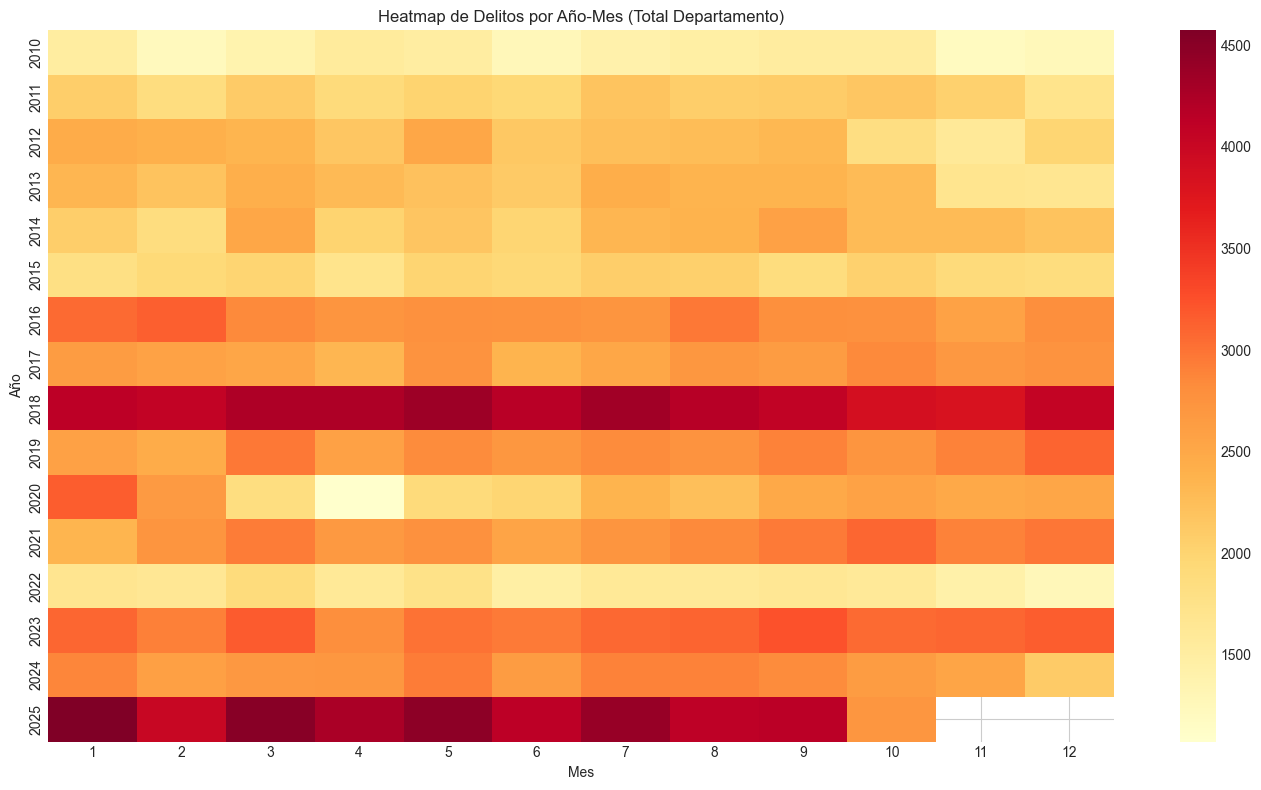

In [7]:
# Heatmap de delitos por año-mes
pivot = df.groupby(['anio', 'mes'])['total_delitos'].sum().unstack()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, fmt='.0f', ax=ax)
ax.set_title('Heatmap de Delitos por Año-Mes (Total Departamento)')
ax.set_xlabel('Mes')
ax.set_ylabel('Año')
plt.tight_layout()
plt.show()

## 3. Correlaciones

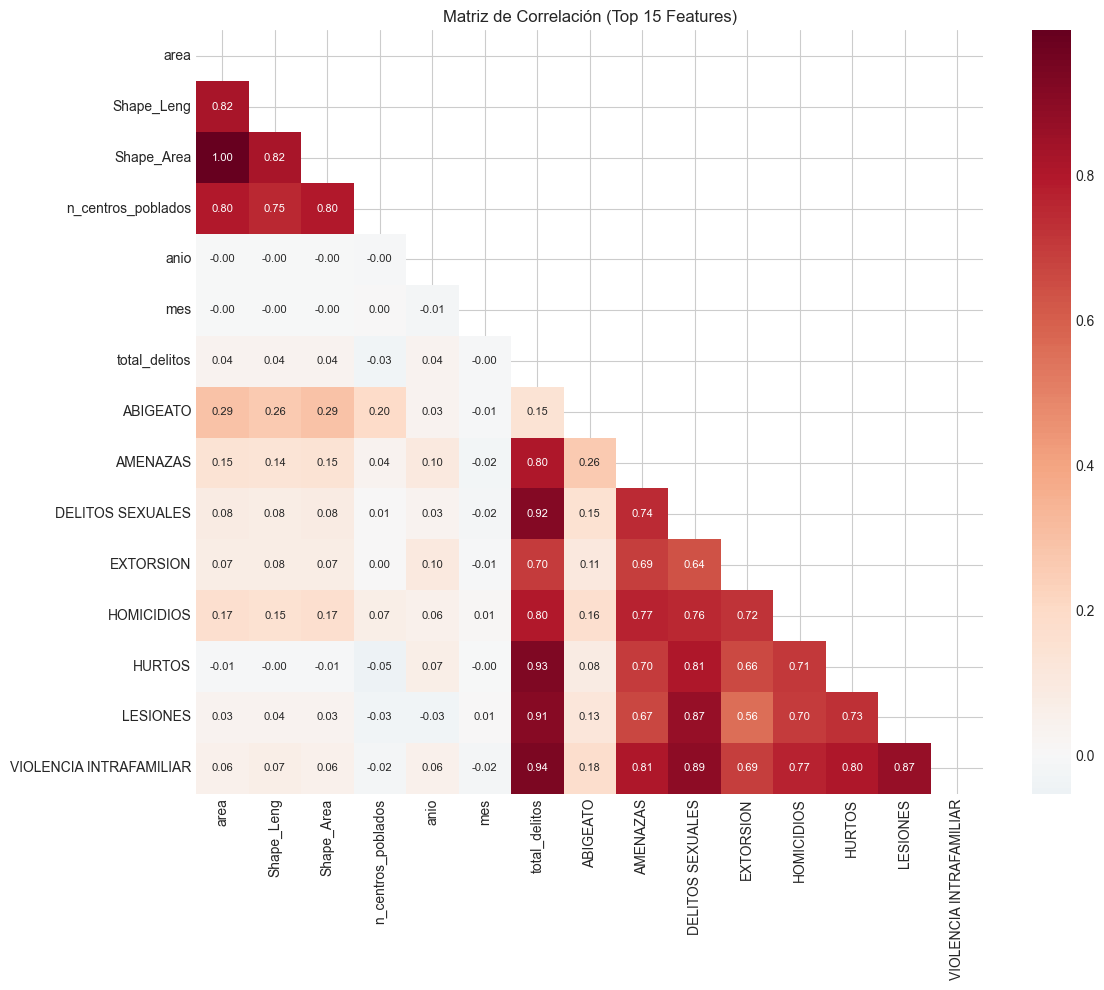

In [8]:
# Identificar features numéricas (excluyendo targets de tasas para claridad)
exclude_cols = ['codigo_municipio'] + [c for c in df.columns if 'tasa_' in c]
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

# Top 15 features
top_features = numeric_cols[:15]

fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, annot_kws={'size': 8})
ax.set_title('Matriz de Correlación (Top 15 Features)')
plt.tight_layout()
plt.show()

In [9]:
# Correlaciones más fuertes con total_delitos
print("=" * 60)
print("CORRELACIONES CON total_delitos")
print("=" * 60)

all_numeric = df.select_dtypes(include=[np.number]).columns
corr_with_target = df[all_numeric].corr()['total_delitos'].drop('total_delitos').sort_values(ascending=False)

print("\nTop 10 positivas:")
print(corr_with_target.head(10).round(3))
print("\nTop 10 negativas:")
print(corr_with_target.tail(10).round(3))

CORRELACIONES CON total_delitos

Top 10 positivas:
roll_mean_3                0.992
lag_1                      0.982
roll_mean_12               0.970
lag_3                      0.964
n_dias_semana              0.952
n_dias_laborales           0.951
VIOLENCIA INTRAFAMILIAR    0.940
n_fines_de_semana          0.936
HURTOS                     0.930
DELITOS SEXUALES           0.919
Name: total_delitos, dtype: float64

Top 10 negativas:
mes                  -0.005
trimestre            -0.005
pct_change_12        -0.019
tasa_abigeato        -0.026
n_centros_poblados   -0.030
pct_change_3         -0.036
pct_change_1         -0.044
proporcion_menores   -0.059
centros_por_km2      -0.060
codigo_municipio     -0.228
Name: total_delitos, dtype: float64


## 4. Análisis de Features Derivadas

In [10]:
# Verificar si hay lag features
lag_cols = [c for c in df.columns if 'lag' in c.lower()]
print("Lag features encontradas:")
print(lag_cols if lag_cols else "Ninguna - Se recomienda crearlas")

# Verificar features de tendencia
trend_cols = [c for c in df.columns if any(x in c.lower() for x in ['trend', 'roll', 'pct_change'])]
print("\nFeatures de tendencia encontradas:")
print(trend_cols if trend_cols else "Ninguna - Se recomienda crearlas")

Lag features encontradas:
['lag_1', 'lag_3', 'lag_12']

Features de tendencia encontradas:
['roll_mean_3', 'roll_mean_12', 'roll_std_3', 'roll_std_12', 'pct_change_1', 'pct_change_3', 'pct_change_12']


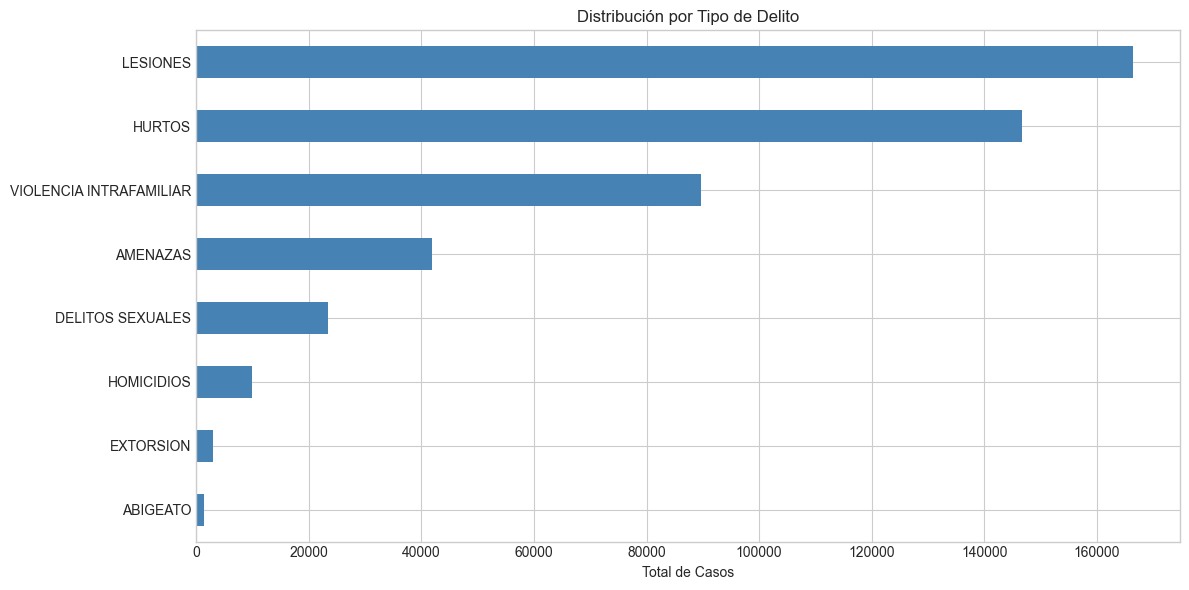

In [12]:
# Distribución de features de tipo de delito
delito_cols = [c for c in df.columns if c in ['ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 
                                               'EXTORSION', 'HOMICIDIOS', 'HURTOS', 
                                               'LESIONES', 'VIOLENCIA INTRAFAMILIAR']]

if delito_cols:
    fig, ax = plt.subplots(figsize=(12, 6))
    df[delito_cols].sum().sort_values(ascending=True).plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Total de Casos')
    ax.set_title('Distribución por Tipo de Delito')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas de tipos de delito individuales")

## 5. Conclusiones y Recomendaciones

In [13]:
print("=" * 60)
print("CONCLUSIONES")
print("=" * 60)

skewness = df['total_delitos'].skew()
zeros = (df['total_delitos'] == 0).sum()

print(f"""
DISTRIBUCIÓN DEL TARGET:
  - Registros: {len(df):,}
  - Media: {df['total_delitos'].mean():.1f}
  - Mediana: {df['total_delitos'].median():.0f}
  - Skewness: {skewness:.2f} ({'Alta asimetría' if abs(skewness) > 1 else 'Moderada'})
  - Valores en cero: {zeros} ({zeros/len(df)*100:.1f}%)

ESTACIONALIDAD:
  - {'Se detecta patrón mensual' if monthly_avg.std() / monthly_avg.mean() > 0.1 else 'Patrón mensual débil'}
  - Mes con más delitos: {monthly_avg.idxmax()}
  - Mes con menos delitos: {monthly_avg.idxmin()}

FEATURES:
  - Total features: {len(df.columns)}
  - Lag features: {'Sí' if lag_cols else 'No (crear)'}
  - Trend features: {'Sí' if trend_cols else 'No (crear)'}
""")

print("\n" + "=" * 60)
print("RECOMENDACIONES PARA MODELO")
print("=" * 60)
print("""
1. TRANSFORMACIÓN:
   - Aplicar log1p() al target si skewness > 1
   - Considerar modelos que manejen zeros

2. FEATURE ENGINEERING:
   - Crear lag features: lag_1, lag_3, lag_12
   - Rolling means: roll_3, roll_6, roll_12
   - Cambio porcentual: pct_change_1, pct_change_12
   - Encodings temporales: mes_sin, mes_cos

3. MODELOS SUGERIDOS:
   - LightGBM / XGBoost (mejor para datos tabulares)
   - Random Forest
   - Prophet (para serie temporal departamental)

4. VALIDACIÓN:
   - TimeSeriesSplit (respetando temporalidad)
   - No usar KFold aleatorio (data leakage)

5. MÉTRICAS:
   - RMSE, MAE en escala original
   - MAPE (cuidado con zeros)
   - R² para varianza explicada
""")

CONCLUSIONES

DISTRIBUCIÓN DEL TARGET:
  - Registros: 12,984
  - Media: 37.1
  - Mediana: 4
  - Skewness: 6.77 (Alta asimetría)
  - Valores en cero: 0 (0.0%)

ESTACIONALIDAD:
  - Patrón mensual débil
  - Mes con más delitos: 3
  - Mes con menos delitos: 11

FEATURES:
  - Total features: 60
  - Lag features: Sí
  - Trend features: Sí


RECOMENDACIONES PARA MODELO

1. TRANSFORMACIÓN:
   - Aplicar log1p() al target si skewness > 1
   - Considerar modelos que manejen zeros

2. FEATURE ENGINEERING:
   - Crear lag features: lag_1, lag_3, lag_12
   - Rolling means: roll_3, roll_6, roll_12
   - Cambio porcentual: pct_change_1, pct_change_12
   - Encodings temporales: mes_sin, mes_cos

3. MODELOS SUGERIDOS:
   - LightGBM / XGBoost (mejor para datos tabulares)
   - Random Forest
   - Prophet (para serie temporal departamental)

4. VALIDACIÓN:
   - TimeSeriesSplit (respetando temporalidad)
   - No usar KFold aleatorio (data leakage)

5. MÉTRICAS:
   - RMSE, MAE en escala original
   - MAPE (cuida

## 6. Guardar Dataset Procesado

In [14]:
# Ruta para guardar dataset procesado
PROCESSED_DATA_PATH = BASE_DIR / 'data' / 'model' / 'regression_monthly_dataset_processed.parquet'

# Crear carpeta si no existe
PROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Guardar dataset
df.to_parquet(PROCESSED_DATA_PATH, index=False)
print(f"✓ Dataset procesado guardado: {PROCESSED_DATA_PATH}")
print(f"  Shape: {df.shape}")
print(f"\nDataset contiene:")
print(f"  - Registros: {len(df):,}")
print(f"  - Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"  - Municipios: {df['codigo_municipio'].nunique()}")
print(f"  - Target: total_delitos (regresión mensual)")
print(f"  - Uso: Modelado de series temporales mensuales")

✓ Dataset procesado guardado: C:\Users\57318\Downloads\mintic\Datos-al-Ecosistema\data\model\regression_monthly_dataset_processed.parquet
  Shape: (12984, 60)

Dataset contiene:
  - Registros: 12,984
  - Período: 2010 - 2025
  - Municipios: 87
  - Target: total_delitos (regresión mensual)
  - Uso: Modelado de series temporales mensuales
